# Example of Metric Learning in Embedded Space

In [3]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml
import random

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
from tqdm import tqdm

# import frnn
import wandb

sys.path.append("../../..")

from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
import copy
from LightningModules.Embedding.utils import build_edges, graph_intersection

device = "cuda" if torch.cuda.is_available() else "cpu"

## Pytorch Lightning Model

In [20]:
with open("example_embedding.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [21]:
model = LayerlessEmbedding(hparams)

## The Dataset

In [4]:
%%time
model.setup(stage="fit")

100%|██████████| 130/130 [00:28<00:00,  4.53it/s]


CPU times: user 5.17 s, sys: 2.77 s, total: 7.94 s
Wall time: 31 s


### Check Merged Hit Definition

In [5]:
trainset = model.trainset

In [6]:
sample = trainset[0]

In [7]:
edge_pids = sample.pid[sample.modulewise_true_edges]

In [8]:
print(f"WHOLE TRUTH GRAPH: {(edge_pids[0] == edge_pids[1]).sum()} matching PIDs, {(edge_pids[0] != edge_pids[1]).sum()} mismatching PIDs, with ratio of {(edge_pids[0] != edge_pids[1]).sum() / (edge_pids[0] == edge_pids[1]).sum()}")

WHOLE TRUTH GRAPH: 126255 matching PIDs, 347 mismatching PIDs, with ratio of 0.0027484060265123844


In [9]:
edge_pids = sample.pid[sample.signal_true_edges]

In [10]:
print(f"pT>1 TRUTH GRAPH: {(edge_pids[0] == edge_pids[1]).sum()} matching PIDs, {(edge_pids[0] != edge_pids[1]).sum()} mismatching PIDs, with ratio of {(edge_pids[0] != edge_pids[1]).sum() / (edge_pids[0] == edge_pids[1]).sum()}")

pT>1 TRUTH GRAPH: 15407 matching PIDs, 0 mismatching PIDs, with ratio of 0.0


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [11]:
trainset = model.trainset

In [12]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [13]:
x, y = r * np.cos(phi * np.pi) * 1000, r * np.sin(phi * np.pi) * 1000
r, z = r * 1000, z * 1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

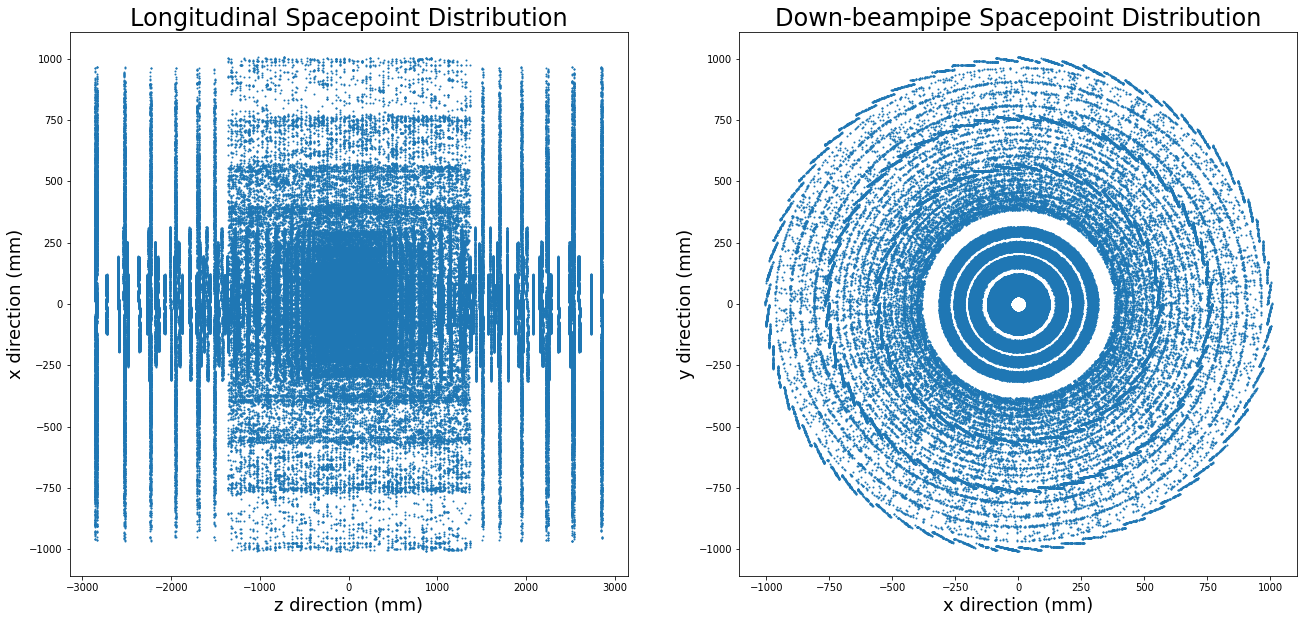

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(22, 10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[
    0
].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel(
    "x direction (mm)", fontsize=18
)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[
    1
].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel(
    "y direction (mm)", fontsize=18
)

### Visualise distributions

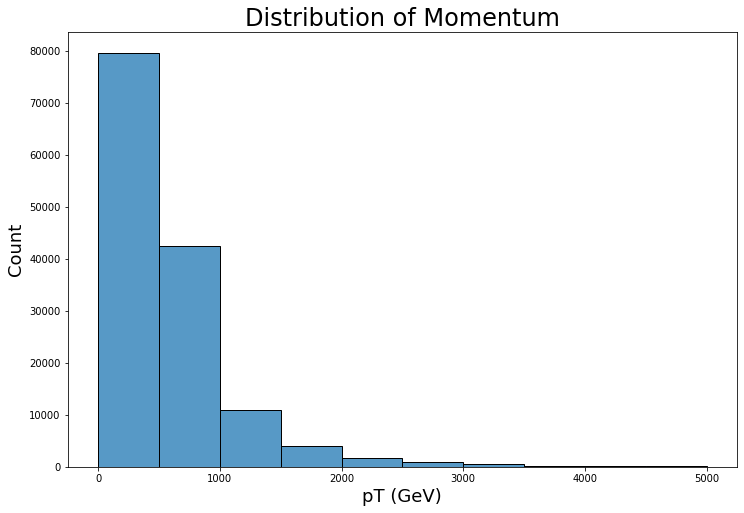

In [15]:
plt.figure(figsize=(12, 8))
sns.histplot(
    example_data.pt[example_data.pt == example_data.pt],
    binwidth=500,
    binrange=[0, 5000],
)
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel(
    "pT (GeV)", fontsize=18
), plt.ylabel("Count", fontsize=18);

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


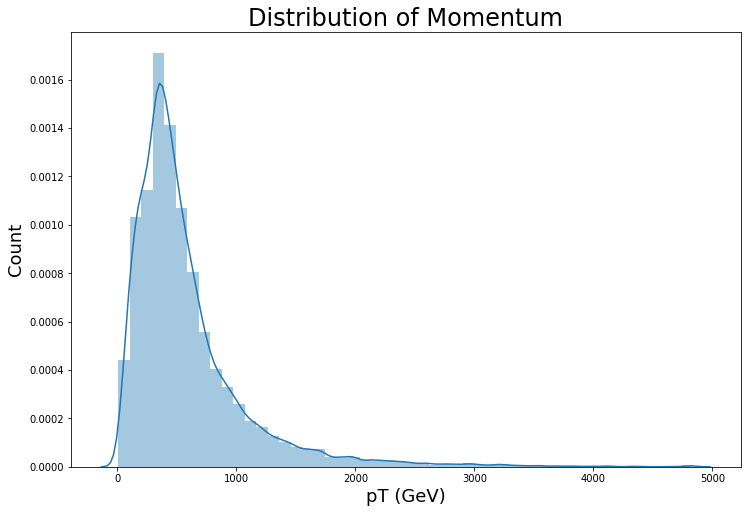

In [16]:
plt.figure(figsize=(12, 8))
sns.distplot(
    example_data.pt[(example_data.pt == example_data.pt) & (example_data.pt < 5000)]
)
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel(
    "pT (GeV)", fontsize=18
), plt.ylabel("Count", fontsize=18);

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [17]:
particle_count_list = [
    len(np.unique(sample.pid.numpy(), return_counts=True)[1][1:]) for sample in trainset
]

In [20]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts=True)

Number of particles: 16560


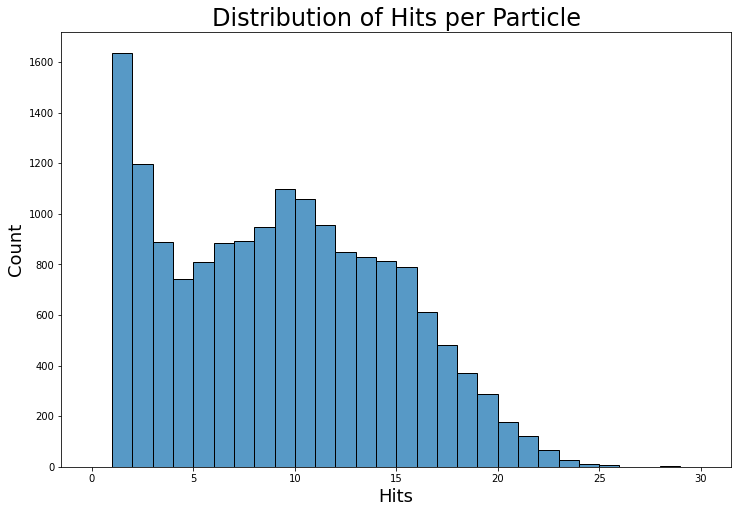

In [21]:
plt.figure(figsize=(12, 8))
sns.histplot(particle_counts[1:], binwidth=1, binrange=[0, 30])
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel(
    "Hits", fontsize=18
), plt.ylabel("Count", fontsize=18)
print("Number of particles:", len(particle_num))

In [22]:
example_data

Data(x=[322574, 3], cell_data=[322574, 11], pid=[322574], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000013917', hid=[322574], pt=[322574], primary=[322574], nhits=[322574], module_id=[322574], modulewise_true_edges=[2, 126602], signal_true_edges=[2, 15407])

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

### Weight Definition

In [10]:
example_data.pt / 1000

tensor([0.3575, 1.0444, 0.2595,  ...,    nan,    nan, 0.3216],
       dtype=torch.float64)

In [11]:
example_data

Data(cell_data=[346145, 11], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010082", hid=[346145], modulewise_true_edges=[2, 131895], nhits=[346145], pid=[346145], primary=[346145], pt=[346145], signal_true_edges=[2, 106747], x=[346145, 3])

### Cell Info

In [20]:
cell_features = [
    "norm_x",
    "norm_y",
    "barrel_endcap",
    "layer_disk",
    "eta_module",
    "phi_module",
    "eta_angle_1",
    "phi_angle_1",
    "eta_angle_2",
    "phi_angle_2",
    "pixel",
]

In [21]:
example_data.cell_data

tensor([[ 0.3610,  0.1495,  0.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000, -2.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  2.0000,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3239,  0.0059,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  0.5373,  0.0064,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3246,  0.0064,  0.0000]])

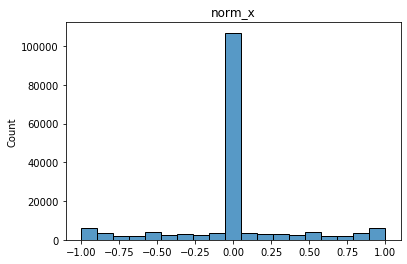

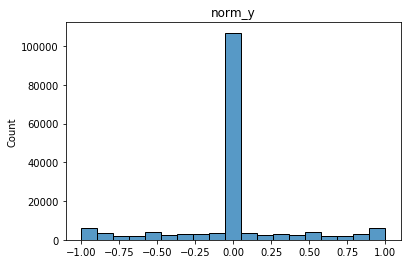

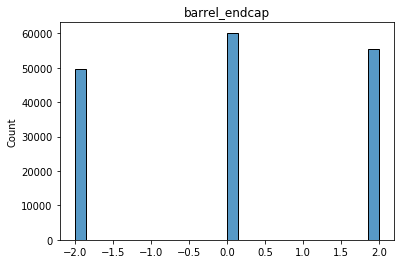

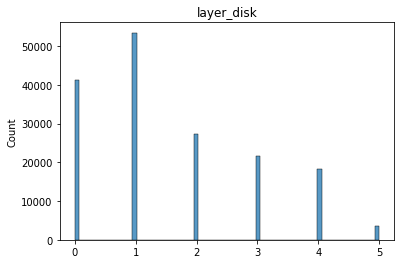

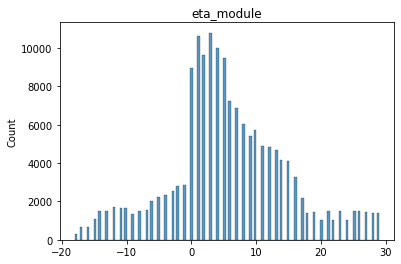

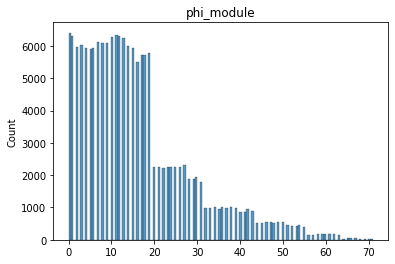

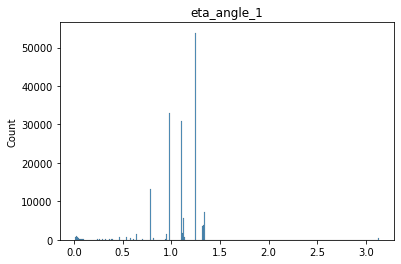

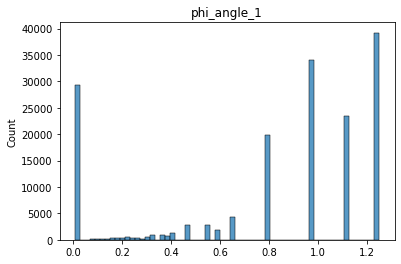

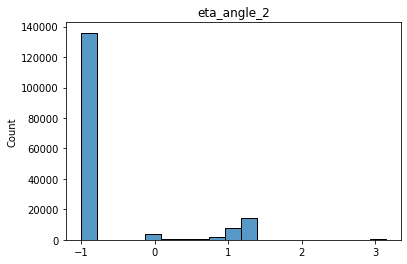

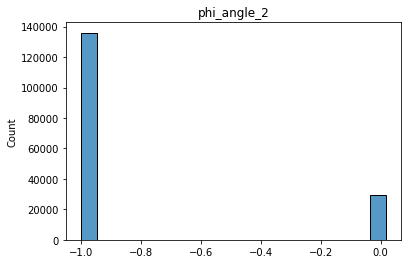

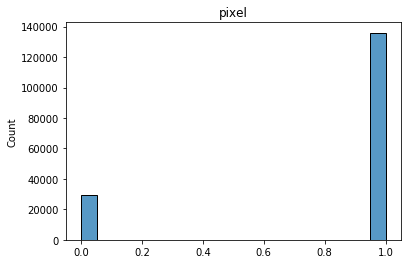

In [22]:
for i, feature in enumerate(cell_features):
    plt.figure()
    sns.histplot(example_data.cell_data[:, i].numpy()).set_title(feature)

## Informational Distribution

In [16]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))

In [17]:
eta = calc_eta(r, z)

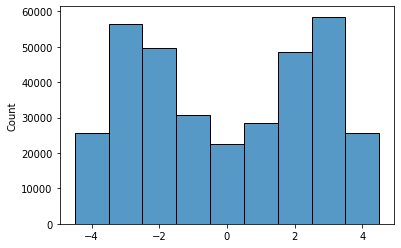

In [26]:
sns.histplot(eta, binrange=[-4, 4], binwidth=0.5)

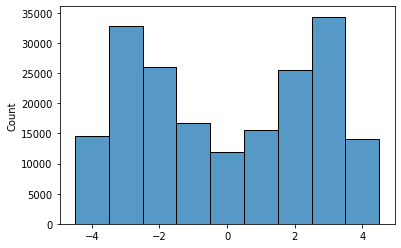

In [29]:
sns.histplot(eta[example_data.pid == 0], binrange=[-4, 4], binwidth=0.5)

In [27]:
example_data

Data(cell_data=[346145, 11], event_file="/project/projectdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010082", hid=[346145], modulewise_true_edges=[2, 131895], nhits=[346145], pid=[346145], primary=[346145], pt=[346145], signal_true_edges=[2, 15456], x=[346145, 3])

In [81]:
list(zip(np.arange(-4, 3, 2), np.arange(-2, 5, 2)))

[(-4, -2), (-2, 0), (0, 2), (2, 4)]

In [89]:
info_fraction = []

for eta_lower, eta_upper in zip(np.arange(-4, 4, 1), np.arange(-3, 5, 1)):
    contained_pids, contained_hits = example_data.pid[
        (eta < eta_upper) & (eta > eta_lower)
    ].unique(return_counts=True)
    contained_pids, contained_hits = contained_pids[1:], contained_hits[1:]

    all_pids, all_hits = example_data.pid.unique(return_counts=True)
    all_pids, all_hits = all_pids, all_hits

    segment = pd.DataFrame(
        np.array([contained_pids.numpy(), contained_hits.numpy()]).T,
        columns=["pid", "segment_count"],
    )
    whole_detector = pd.DataFrame(
        np.array([all_pids.numpy(), all_hits.numpy()]).T, columns=["pid", "all_count"]
    )

    segment = segment.merge(whole_detector, on="pid")
    info_fraction.append(
        (segment.segment_count / segment.all_count).sum() / len(segment)
    )

In [92]:
list(zip(np.arange(-4, 4, 1), np.arange(-3, 5, 1)))

[(-4, -3), (-3, -2), (-2, -1), (-1, 0), (0, 1), (1, 2), (2, 3), (3, 4)]

In [94]:
info_fraction

[0.8042990455368475,
 0.7255421577989447,
 0.6976981433751849,
 0.6268454839016514,
 0.6093671360672268,
 0.6733587499256661,
 0.734833645789457,
 0.8014814478604929]

In [104]:
info_fraction = [
    0.8042990455368475,
    0.7355421577989447,
    0.6776981433751849,
    0.6068454839016514,
    0.6093671360672268,
    0.6733587499256661,
    0.734833645789457,
    0.8014814478604929,
]

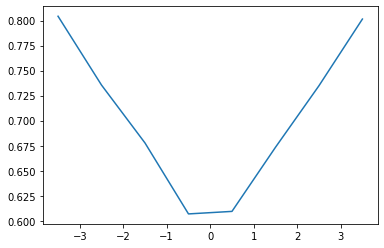

In [105]:
plt.plot(np.arange(-3.5, 4, 1), info_fraction)

In [69]:
eta_lower, eta_upper = 2, 4

In [70]:
contained_pids, contained_hits = example_data.pid[
    (eta < eta_upper) & (eta > eta_lower)
].unique(return_counts=True)
contained_pids, contained_hits = contained_pids[1:], contained_hits[1:]

In [71]:
all_pids, all_hits = example_data.pid.unique(return_counts=True)
all_pids, all_hits = all_pids, all_hits

In [72]:
segment = pd.DataFrame(
    np.array([contained_pids.numpy(), contained_hits.numpy()]).T,
    columns=["pid", "segment_count"],
)

In [73]:
whole_detector = pd.DataFrame(
    np.array([all_pids.numpy(), all_hits.numpy()]).T, columns=["pid", "all_count"]
)

In [74]:
segment

,pid,segment_count
0,807,19
1,888,5
2,890,13
3,891,15
4,892,17
...,...,...
5352,68770200712,4
5353,68780000033,1
5354,68780000036,14
5355,68780000051,10


In [75]:
whole_detector

,pid,all_count
0,0,191652
1,751,1
2,754,14
3,773,10
4,774,10
...,...,...
17517,68780200067,1
17518,68780200076,1
17519,68780200080,1
17520,68780200088,5


In [76]:
segment = segment.merge(whole_detector, on="pid")

In [67]:
inner_info_fraction = (segment.segment_count / segment.all_count).sum() / len(segment)

In [77]:
outer_info_fraction = (segment.segment_count / segment.all_count).sum() / len(segment)

In [68]:
inner_info_fraction

0.7581689500253166

In [78]:
outer_info_fraction

0.8696070573745031

## Metric Learning

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [6]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="eff", mode="max", save_top_k=2, save_last=True
)

In [7]:
logger = WandbLogger(
    project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1,
    max_epochs=hparams["max_epochs"],
    logger=logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
100%|██████████| 80/80 [00:10<00:00,  7.67it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Set SLURM handle signals.

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.739    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


torch.Size([106984805])
Validation sanity check:  50%|█████     | 1/2 [00:06<00:06,  6.34s/it]

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


torch.Size([100600429])
                                                                      

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  71%|███████▏  | 50/70 [00:26<00:10,  1.87it/s, loss=0.0105, v_num=dbqs]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/20 [00:00<?, ?it/s]torch.Size([139410392])

Epoch 0:  74%|███████▍  | 52/70 [00:35<00:12,  1.47it/s, loss=0.0105, v_num=dbqs]torch.Size([130849070])

Validating:  10%|█         | 2/20 [00:16<02:22,  7.91s/it]torch.Size([123260503])

Epoch 0:  77%|███████▋  | 54/70 [00:49<00:14,  1.09it/s, loss=0.0105, v_num=dbqs]torch.Size([142080471])

Epoch 0:  79%|███████▊  | 55/70 [00:58<00:15,  1.06s/it, loss=0.0105, v_num=dbqs]torch.Size([148020863])

Epoch 0:  80%|████████  | 56/70 [01:07<00:16,  1.20s/it, loss=0.0105, v_num=dbqs]torch.Size([148157850])

Epoch 0:  81%|████████▏ | 57/70 [01:16<00:17,  1.34s/it, loss=0.0105, v_num=dbqs]torch.Size([145546378])

Epoch 0:  83%|████████▎ | 58/70 [01:24<00:17,  1.45s/it, loss=0.0105, v_num=dbqs]torch.Size([155884945])

Epoch 0:  84%|████████▍ | 59/70 [01:33<00:17,  1.59s/it, loss=0.0105, v_num=dbqs]OOM
torch.Si

/global/homes/d/danieltm/.conda/envs/exatrkx-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Test embedding

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [13]:
from LightningModules.Embedding.utils import get_metrics

Let's see how well the model learned to embed the hits into a space that separates them into discrete clusters. As in the data visualisation above, we are going manual here. So one thing we need to do is tell the model that we are **evaluating**, not **training**, with `model.eval()`. We also make sure to wrap everything with `with torch.no_grad()` to ignore any gradients. This speeds things up and gives the GPU's memory a rest, since we're not interesting in any kind of training from here on in.

In [14]:
model.eval();

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)[0]

        mean_efficiency, mean_purity = test_results["eff"], test_results["pur"]

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

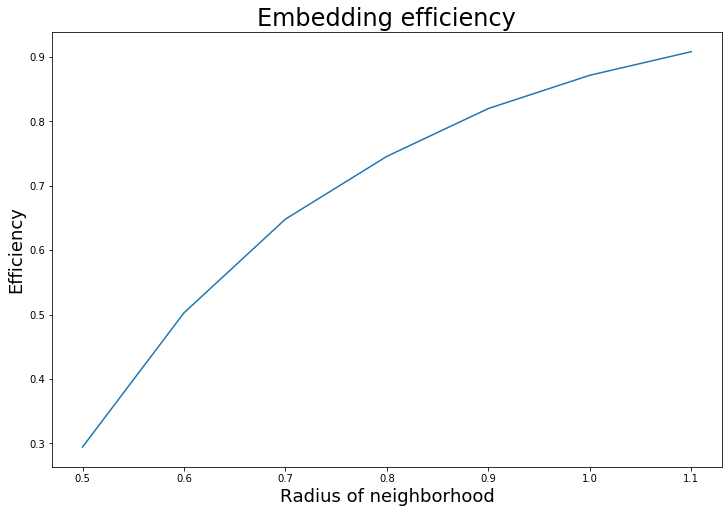

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(all_radius, all_efficiencies)
plt.title("Embedding efficiency", fontsize=24), plt.xlabel(
    "Radius of neighborhood", fontsize=18
), plt.ylabel("Efficiency", fontsize=18);

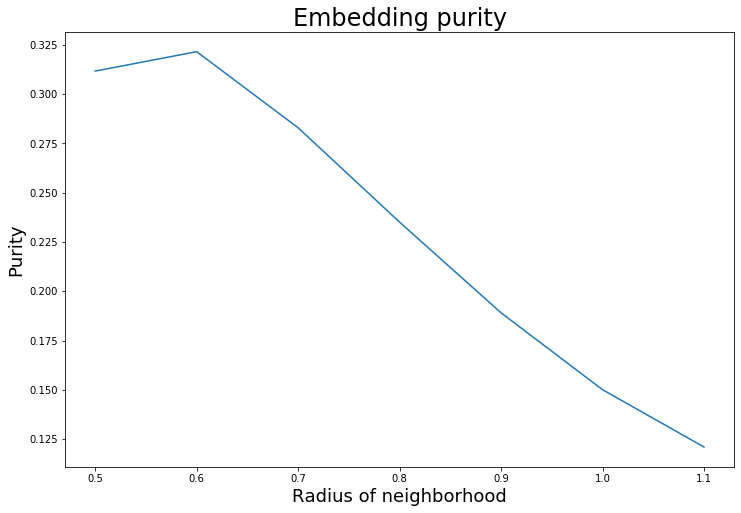

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(all_radius, all_purities)
plt.title("Embedding purity", fontsize=24), plt.xlabel(
    "Radius of neighborhood", fontsize=18
), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

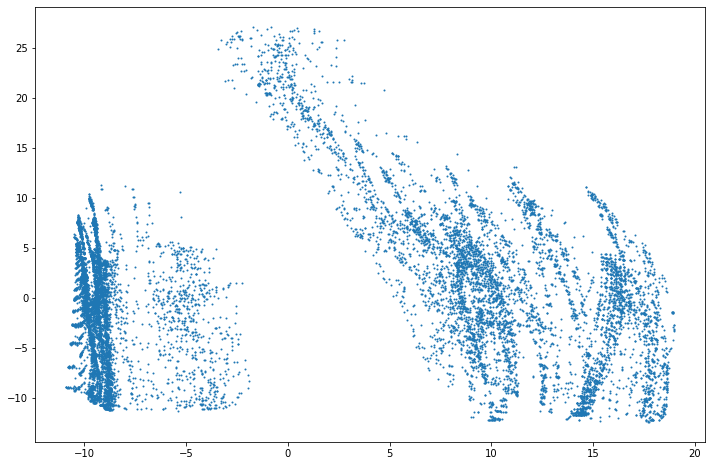

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

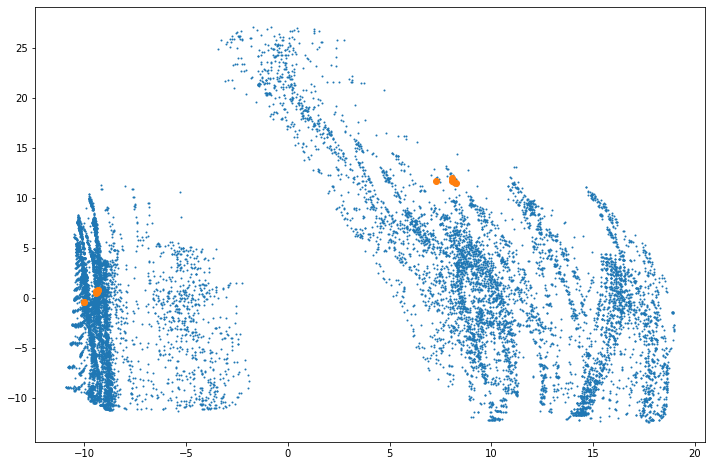

In [33]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(
    reduced_dimensions[particle_ids == example_particle, 0],
    reduced_dimensions[particle_ids == example_particle, 1],
)

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

### Distributions

In [4]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))

In [5]:
def get_performance(model, batch, r_max, k_max):
    with torch.no_grad():
        results = model.shared_evaluation(batch, 0, r_max, k_max)

    return results["truth"], results["preds"], results["truth_graph"]

In [8]:
r_max = 0.1
k_max = 1000

In [13]:
%%time
batch = 0
model.eval()

y_cluster, e_spatial, e_bidir = get_performance(
    model, model.testset[batch].to(device), r_max=r_max, k_max=k_max
)

CPU times: user 2.45 s, sys: 980 ms, total: 3.43 s
Wall time: 3.11 s


In [22]:
module_mask = model.testset[batch].modules[e_spatial[0]] != model.testset[batch].modules[e_spatial[1]]

In [27]:
y_cluster, e_spatial = y_cluster[module_mask], e_spatial[:, module_mask]

In [24]:
print(
    f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}"
)

Pur: 0.002205710159614682, Eff: 0.9884524941444397


In [28]:
print(
    f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}"
)

Pur: 0.0025278725661337376, Eff: 0.9884524941444397


In [10]:
eta_cuts = np.arange(-4, 4.5, 0.5)
batch_range = np.arange(0, 50)

eta_eff_list = []
eta_pur_list = []

for batch_idx in tqdm(batch_range):

    batch = model.testset[batch_idx].to(device)

    y_cluster, e_spatial, e_bidir = get_performance(
        model, batch, r_max=r_max, k_max=k_max
    )
    module_mask = model.testset[batch_idx].modules[e_spatial[0]] != model.testset[batch_idx].modules[e_spatial[1]]
    y_cluster, e_spatial = y_cluster[module_mask], e_spatial[:, module_mask]

    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[e_spatial[0]] + eta_hits[e_spatial[1]]) / 2
    av_eta_true = (eta_hits[e_bidir[0]] + eta_hits[e_bidir[1]]) / 2

    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_true = (av_eta_true >= eta1) & (av_eta_true <= eta2)
        true_positives = y_cluster[edge_eta_pred]

        eta_eff_list.append(true_positives.sum().item() / edge_eta_true.sum().item())
        eta_pur_list.append(true_positives.sum().item() / true_positives.shape[0])

100%|██████████| 50/50 [01:38<00:00,  1.96s/it]


In [11]:
eta_eff_reshape = np.array(eta_eff_list).reshape(
    len(batch_range), eta_cuts.shape[0] - 1
)
eta_pur_reshape = np.array(eta_pur_list).reshape(
    len(batch_range), eta_cuts.shape[0] - 1
)

(0.96, 1.005)

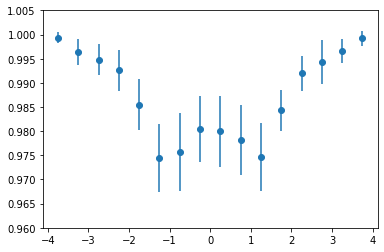

In [12]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), fmt="o")
plt.ylim(0.96, 1.005)

(0.0, 0.01)

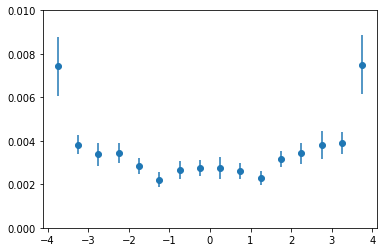

In [19]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_pur_reshape.mean(0), eta_pur_reshape.std(0), fmt="o")
plt.ylim(0., 0.01)

In [22]:
pt_cuts = np.arange(250, 5000, 500)
batch_range = np.arange(0, 50)

pt_eff_list = []
pt_pur_list = []

for batch_idx in tqdm(batch_range):

    batch = model.testset[batch_idx].to(device)

    y_cluster, e_spatial, e_bidir = get_performance(
        model, batch, r_max=r_max, k_max=k_max
    )
    module_mask = batch.modules[e_spatial[0]] != batch.modules[e_spatial[1]]
    y_cluster, e_spatial = y_cluster[module_mask], e_spatial[:, module_mask]
    
    av_pt_preds = (batch.pt[e_spatial[0]] + batch.pt[e_spatial[1]]) / 2
    av_pt_true = (batch.pt[e_bidir[0]] + batch.pt[e_bidir[1]]) / 2

    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        true_positives = y_cluster[edge_pt_pred]

        pt_eff_list.append(
            true_positives.sum().item() / max(1, edge_pt_true.sum().item())
        )
        pt_pur_list.append(
            true_positives.sum().item() / max(1, true_positives.shape[0])
        )

100%|██████████| 50/50 [01:14<00:00,  1.50s/it]


In [23]:
pt_eff_reshape = np.array(pt_eff_list).reshape(len(batch_range), pt_cuts.shape[0] - 1)
pt_pur_reshape = np.array(pt_pur_list).reshape(len(batch_range), pt_cuts.shape[0] - 1)

(0.97, 1.005)

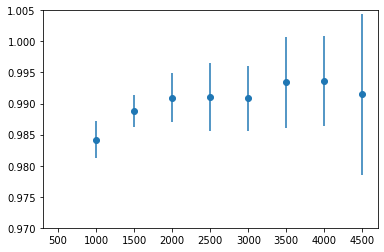

In [26]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_eff_reshape.mean(0), pt_eff_reshape.std(0), fmt="o")
plt.ylim(0.97, 1.005)

This is not meaningful...

<ErrorbarContainer object of 3 artists>

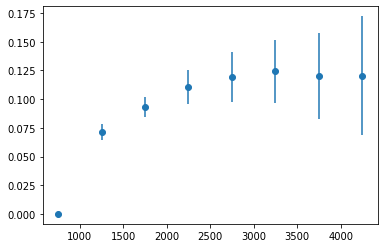

In [18]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_pur_reshape.mean(0), pt_pur_reshape.std(0), fmt="o")

## Memory of Edge Builder

In [29]:
torch.cuda.max_memory_allocated() / 1024**3

4.934445381164551

In [26]:
torch.cuda.reset_peak_memory_stats()

In [8]:
r_max = 1.6
k_max = 1000

In [9]:
batch = model.testset[0].to(device)
model.eval()
with torch.no_grad():
    input_data = torch.cat(
        [batch.cell_data[:, : model.hparams["cell_channels"]], batch.x], axis=-1
    )
    input_data[input_data != input_data] = 0
    spatial = model(input_data)
    e_bidir = torch.cat(
        [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
    )

In [11]:
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=spatial.unsqueeze(0),
    points2=spatial.unsqueeze(0),
    lengths1=None,
    lengths2=None,
    K=k_max,
    r=r_max,
    grid=None,
    return_nn=False,
    return_sorted=True,
)

In [13]:
idxs = idxs.squeeze().int()
ind = torch.Tensor.repeat(
    torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1
).T.int()

In [15]:
positive_idxs = idxs >= 0
ind = ind[positive_idxs]
idxs = idxs[positive_idxs]

In [17]:
edge_list = torch.stack([ind, idxs]).int()

In [19]:
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

In [24]:
del ind
del idxs

In [28]:
edge_list = edge_list.long()

# Build Edge Dataset

## Load best model

In [6]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Embedding/dk8judyz/checkpoints/epoch=99-step=24999.ckpt"
checkpoint = torch.load(checkpoint_path)

In [7]:
model = LayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [5]:
model.hparams["train_split"] = [8000, 100, 100]
# model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_barrel"

In [6]:
model.hparams["train_split"] = [1, 1, 300]
model.hparams["input_dir"] = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_uncorrelated"

In [7]:
model.setup(stage="fit")

100%|██████████| 202/202 [00:56<00:00,  3.59it/s]


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [36]:
model = model.to(device)
# batch = model.trainset[0].to(device)
# results = model.shared_evaluation(batch, 0, 0.1, 1000, log=False)

t, p, tp = [], [], []
radius = 0.125

model.eval()
with torch.no_grad():
    for data in tqdm(model.trainset):
        batch = data.to(device)
        results = model.shared_evaluation(batch, 0, radius, 1000, log=False)
        t.append(results["truth_graph"].shape[1])
        p.append(results["preds"].shape[1])
        tp.append(results["truth"].sum())

t = np.array(t)
p = np.array(p)
tp = np.array(tp)

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


Uncorrelated events:

In [33]:
print("Efficiency:", tp.sum() / t.sum(), "Purity:", tp.sum() / p.sum(), "Radius:", radius)

Efficiency: 0.9883244513208412 Purity: 0.002679319420477218 Radius: 0.1


In [35]:
print("Efficiency:", tp.sum() / t.sum(), "Purity:", tp.sum() / p.sum(), "Radius:", radius)

Efficiency: 0.9928872270930033 Purity: 0.002033334898509062 Radius: 0.11


In [37]:
print("Efficiency:", tp.sum() / t.sum(), "Purity:", tp.sum() / p.sum(), "Radius:", radius)

Efficiency: 0.9971849750730617 Purity: 0.0013527566706018704 Radius: 0.125


## Define Building Class

In [8]:
class EmbeddingInferenceBuilder:
    def __init__(self, model, split = [100, 10, 10], overwrite=False, knn_max = 1000, radius = 0.1):
        
        self.model = model
        self.output_dir = self.model.hparams["output_dir"]
        self.input_dir = self.model.hparams["input_dir"]
        self.overwrite = overwrite
        self.split = split
        self.knn_max = knn_max
        self.radius = radius
        
        single_file_split = [1, 1, 1]
        model.hparams["train_split"] = single_file_split
        model.setup(stage="fit")
        

    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = self.prepare_datastructure()
        
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for event in tqdm(dataset):
                    
                    event_file = os.path.join(self.input_dir, event)
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch = torch.load(event_file).to(self.model.device)
                        self.construct_downstream(batch, datatype)

    def prepare_datastructure(self):
        # Prep the directory to produce inference data to
        self.output_dir = self.model.hparams.output_dir
        self.datatypes = ["train", "val", "test"]

        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]

        all_events = os.listdir(self.model.hparams["input_dir"])
        random.shuffle(all_events)
        self.dataset_list = np.split(np.array(all_events), np.cumsum(self.split))
        
        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": list(self.dataset_list[0]),
            "val": list(self.dataset_list[1]),
            "test": list(self.dataset_list[2]),
        }
        
        return datasets
                        
    def construct_downstream(self, batch, datatype):

        batch = self.select_data(batch)
        
        y_cluster, e_spatial, e_bidir = get_performance(
            model, batch, r_max= self.radius, k_max=self.knn_max
        )
        
        module_mask = batch.modules[e_spatial[0]] != batch.modules[e_spatial[1]]
        y_cluster, e_spatial = y_cluster[module_mask], e_spatial[:, module_mask]
        
        # Arbitrary ordering to remove half of the duplicate edges
        R_dist = torch.sqrt(batch.x[:, 0] ** 2 + batch.x[:, 2] ** 2)
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

        e_spatial, y_cluster = self.model.get_truth(batch, e_spatial, e_bidir)

        # Re-introduce random direction, to avoid training bias
        random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
        e_spatial[0, random_flip], e_spatial[1, random_flip] = (
            e_spatial[1, random_flip],
            e_spatial[0, random_flip],
        )

        batch.edge_index = e_spatial
        batch.y = y_cluster

        self.save_downstream(batch, datatype)

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)
            
    def select_data(self, event):
    
        event.signal_true_edges = event.modulewise_true_edges
        
        if (
            ("pt" in event.keys)
            & ("primary" in event.keys)
            & ("nhits" in event.keys)
        ):
            edge_subset = (
                (event.pt[event.signal_true_edges] > 1000).all(0)
                & (event.nhits[event.signal_true_edges] >= 3).all(0)
                & (event.primary[event.signal_true_edges].bool().all(0))
            )

            event.signal_true_edges = event.signal_true_edges[:, edge_subset]
        
        return event

In [9]:
model.hparams.output_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0GeV_uncorrelated_large"
edge_builder = EmbeddingInferenceBuilder(model, split=[1, 1, 300], overwrite=False, knn_max=1000, radius=0.125)

100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


In [10]:
edge_builder.build()

Training finished, running inference to build graphs...


  4%|▎         | 11/300 [00:51<22:22,  4.65s/it]


KeyboardInterrupt: 

In [48]:
os.listdir("/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0GeV_uncorrelated_large/test")

['3505',
 '5017',
 '3005',
 '5503',
 '5003',
 '2003',
 '3506',
 '7501',
 '4501',
 '3006',
 '0510',
 '4001',
 '7516',
 '1509',
 '1009',
 '4502',
 '0007',
 '4002',
 '4517',
 '8512',
 '5512',
 '3508',
 '0508',
 '4503',
 '0008',
 '4003',
 '7010',
 '1003',
 '4010',
 '8009',
 '5513',
 '8520',
 '3501',
 '2006',
 '3001',
 '4504',
 '0009',
 '1004',
 '2507',
 '5514',
 '3502',
 '9005',
 '5014',
 '3002',
 '3517',
 '1505',
 '0017',
 '1005',
 '4012',
 '5515',
 '3503',
 '0003',
 '3010',
 '7009',
 '2501',
 '1006',
 '4013',
 '2001',
 '9507',
 '8523',
 '3504',
 '9007',
 '0504',
 '0004',
 '3011',
 '1507',
 '2502',
 '1014',
 '2002',
 '9508',
 '2517',
 '0505',
 '3512',
 '0005',
 '1508',
 '4515',
 '9001',
 '2010',
 '0506',
 '9016',
 '1501',
 '0006',
 '0013',
 '1001',
 '2504',
 '8007',
 '2511',
 '2011',
 '0507',
 '1502',
 '0014',
 '1002',
 '8508',
 '8008',
 '5008',
 '2512',
 '9003',
 '2012',
 '7506',
 '7006',
 '4510',
 '8001',
 '0015',
 '8509',
 '9504',
 '4525',
 '2513',
 '9004',
 '0501',
 '0001',
 '0516',
 

In [49]:
sample = torch.load("/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0GeV_uncorrelated_large/test/3505")

In [50]:
sample

Data(x=[332410, 3], cell_data=[332410, 11], pid=[332410], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/uncorrelated_events/event000003505', hid=[332410], pt=[332410], primary=[332410], nhits=[332410], modules=[332410], modulewise_true_edges=[2, 131168], signal_true_edges=[2, 15229], edge_index=[2, 10770071], y=[10770071])

In [52]:
sample.y.sum() / sample.y.shape[0]

tensor(0.0014)

In [53]:
sample.y.sum() / sample.signal_true_edges.shape[1]

tensor(0.9957)